# Sparkify Project Workspace

This project is the analysis of user logs for a music streaming service called "Sparkify". The Sparkify music service company wants to identify the users that might churn in future. Once the reasons for churn are better undestood, our goal is to build a model and predict the users that will churn so that additional attention/perks can be given to the users and try to retain them on the platform.

We will be leveraging a subset of user log dataset for this analysis. This dataset contains the logs of the user actions such as subscription details, pages visited, location, time etc.

# Importing libraries

In [1]:
#!pip install pyspark
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from sklearn import metrics
import builtins as p
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as sql_fun
from pyspark.sql.functions import *
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Creating sparksession and setting an app name

In [2]:
spark = SparkSession \
    .builder \
    .appName("Music App") \
    .getOrCreate()

In [3]:
spark

# Load and Clean Dataset

In [4]:
#Loading the raw data
path = "mini_sparkify_event_data.json"
music_app_raw_data = spark.read.json(path)
music_app_raw_data.toPandas().head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [5]:
#Checking schema and shape of the raw dataset
print(music_app_raw_data.printSchema())
print(music_app_raw_data.toPandas().shape)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None
(286500, 18)


In [6]:
#Checking summary of all columns present in the raw dataset
for c in music_app_raw_data.columns:
    music_app_raw_data.describe(c).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max| 

In [7]:
#Checking null values present in the raw data
print(music_app_raw_data.toPandas().isnull().sum())

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64


In [8]:
#Identifying records that have invalid userIds
music_app_raw_data.groupBy("userId").count().orderBy("userId").show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [9]:
#Identifying records that have invalid sessionIds
music_app_raw_data.groupBy("sessionId").count().orderBy("sessionId").show()

+---------+-----+
|sessionId|count|
+---------+-----+
|        1|  714|
|        2|    7|
|        3|   38|
|        4|   24|
|        5|   58|
|        6|   71|
|        7|    1|
|        8|   49|
|        9|  197|
|       10|  176|
|       11|   47|
|       12|   60|
|       13|  122|
|       15|  220|
|       16|   39|
|       17|  171|
|       18|   30|
|       19|  158|
|       20|   29|
|       21|  138|
+---------+-----+
only showing top 20 rows



In [10]:
#Since some records don't have a valid userId so removing the records
music_app_raw_data = music_app_raw_data.filter(music_app_raw_data.userId!="")
music_app_raw_data.toPandas().shape

(278154, 18)

In [11]:
#Extracting region from the location field
music_app_data_location = music_app_raw_data.withColumn('region', F.split(music_app_raw_data.location, ', ')[1])
music_app_data_location.toPandas().head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,region
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH


In [12]:
#Converting the timestamp(ts) column to a meaningful datetime format
set_time = F.udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
music_app_data = music_app_data_location.withColumn("time", F.to_timestamp(set_time(music_app_data_location.ts), 'yyyy-MM-dd HH:mm:ss'))
music_app_data.toPandas().head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,region,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH,2018-10-01 00:03:00


# Exploratory Data Analysis
In the following section, we will perform exploratory data analysis to understand the data distribution better. Additionally, we will define a churn field by leveraging existing field present in the data.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churn. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
#Creating a churn flag that contains "yes" or "no"
churn_users = music_app_data.filter(music_app_data.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = churn_users.toPandas()['userId'].values.tolist()
music_app_data_interim = music_app_data.withColumn('churn', music_app_data.userId.isin(churn_users_list))
print("Count of all users present in the data:")
print(music_app_data_interim.select(F.countDistinct("userId")).show())
print("Count of churn users:")
print(len(churn_users_list))
music_app_data_interim = music_app_data_interim.withColumn("churn", \
              when(music_app_data_interim["churn"] == True, "Yes").otherwise("No"))

Count of all users present in the data:
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+

None
Count of churn users:
52


In [14]:
#Creating a copy of spark dataframe
music_app_final_spark_df = music_app_data_interim.alias('music_app_final_spark_df')
music_app_final_spark_df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+------+-------------------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|region|               time|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+------+-------------------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    CA|2018-10-01 00:01:57|   No|
+--------------+---------+---------+------+-------------+--------+---------+

In [15]:
#Converting the spark dataframe to a pandas dataframe
music_app_final_df = music_app_data_interim.toPandas().copy()
music_app_final_df.head(1)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,region,time,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:01:57,No


In [16]:
#Checking the count of downgrade users
downgrade_users = list(music_app_final_df[music_app_final_df['page'] == 'Submit Downgrade']['userId'].unique())
print(len(downgrade_users))
print(list(set(churn_users_list) & set(downgrade_users)))

49
['54', '100012', '100009', '100025', '12', '200020', '103', '100015', '200011']


<h5> I think we should not classify the downgrade users as churn users since they are still using the service and might upgrade back in near future. So, we are considering only cancelled users because they don't have any activity post cancellation.

In [17]:
music_app_data_interim.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,region,time,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:01:57,No
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH,2018-10-01 00:03:00,No
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:06:34,No
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH,2018-10-01 00:06:56,No
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:11:16,No


In [18]:
#Aggregated all the important fields at user level
music_app_df_user_level = music_app_data_interim.groupBy('userId').agg(F.min('gender').alias('gender'),
                                                   F.min('region').alias('region'),
                                                   F.min('ts').alias('firstSession'), 
                                                   F.max('ts').alias('lastSession'),
                                                   F.count('song').alias('songsListened'),
                                                   F.count('sessionId').alias('totalSessions'),
                                                   F.min('churn').alias('churn')).sort('userId')

music_app_df_user_level = music_app_df_user_level.withColumn("firstSession", \
                    F.to_timestamp(set_time(music_app_df_user_level.firstSession),'yyyy-MM-dd HH:mm:ss'))
music_app_df_user_level = music_app_df_user_level.withColumn("lastSession", \
                    F.to_timestamp(set_time(music_app_df_user_level.lastSession),'yyyy-MM-dd HH:mm:ss'))
music_app_df_user_level = music_app_df_user_level.withColumn('totalDays', F.datediff("lastSession", "firstSession"))

In [19]:
music_app_df_user_level.toPandas().head()

,userId,gender,region,firstSession,lastSession,songsListened,totalSessions,churn,totalDays
0,10,M,MS,2018-10-08 02:20:20,2018-11-19 12:49:48,673,795,No,42
1,100,M,TX,2018-10-02 15:04:22,2018-11-30 14:15:49,2682,3214,No,59
2,100001,F,FL,2018-10-01 06:48:24,2018-10-02 16:36:45,133,187,Yes,1
3,100002,F,CA,2018-10-08 22:57:25,2018-12-03 01:11:16,195,218,No,56
4,100003,F,FL,2018-10-09 15:53:40,2018-10-11 16:19:41,51,78,Yes,2


In [20]:
#Converting spark dataframe to pandas dataframe and looking at the sample records
music_app_pd_df=music_app_df_user_level.toPandas()
print("Number of rows and columns:")
print(music_app_pd_df.shape)
print("")
print("Sample records:")
music_app_pd_df.head(2)

Number of rows and columns:
(225, 9)

Sample records:


,userId,gender,region,firstSession,lastSession,songsListened,totalSessions,churn,totalDays
0,10,M,MS,2018-10-08 02:20:20,2018-11-19 12:49:48,673,795,No,42
1,100,M,TX,2018-10-02 15:04:22,2018-11-30 14:15:49,2682,3214,No,59


In [21]:
#Checking count of churned and active users
music_app_pd_df.groupby(['churn']).agg({'userId': ['count']})

,userId
,count
churn,
No,173
Yes,52


In [22]:
#Checking count of churned and active users at gender level
churn_rate_gender = music_app_pd_df.groupby(['gender','churn']).agg({'userId': ['count']})
churn_rate_gender = churn_rate_gender.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
churn_rate_gender.reset_index().head()

,gender,churn,userId
,,,count
0,F,No,80.769231
1,F,Yes,19.230769
2,M,No,73.553719
3,M,Yes,26.446281


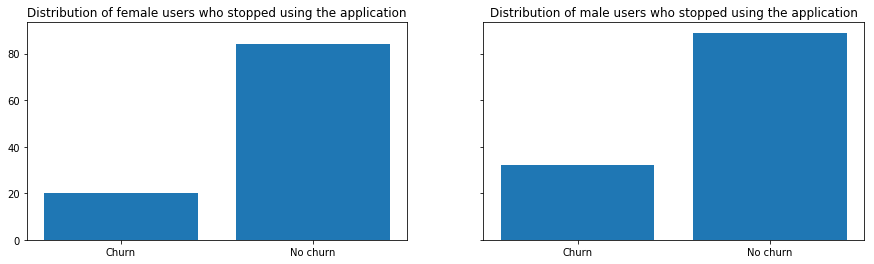

In [23]:
#Checking count of churned and active users at gender level
temp_df = music_app_pd_df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4), sharey=True)
ax1.bar(['No churn', 'Churn'], temp_df[temp_df['gender']=='F'].groupby(['churn'])['userId'].count())
ax2.bar(['No churn', 'Churn'], temp_df[temp_df['gender']=='M'].groupby(['churn'])['userId'].count())
ax1.set_title('Distribution of female users who stopped using the application')
ax2.set_title('Distribution of male users who stopped using the application')
plt.show()

<h5> We observe relatively higher churn rate in males than females.

In [24]:
#Comparing churned users and active users
churn_rate_songs_listened = temp_df.groupby(['churn']).agg({'songsListened': ['median'], 'totalDays': ['median'], 'totalSessions': ['median']})
churn_rate_songs_listened

,songsListened,totalDays,totalSessions
,median,median,median
churn,,,
No,747.0,54,940
Yes,452.5,21,576


In [25]:
#Checking user count at page level
user_count_page_level = music_app_final_df.groupby(['page']).agg({'userId': ['nunique']})
user_count_page_level = user_count_page_level.reset_index()
user_count_page_level.columns = ['page','counts']
user_count_page_level.head(1)
user_count_page_level['counts'] = user_count_page_level['counts'].astype(float)
user_count_page_level.sort_values([('counts')], ascending=False)

,page,counts
10,NextSong,225.0
8,Home,223.0
17,Thumbs Up,220.0
2,Add to Playlist,215.0
9,Logout,213.0
11,Roll Advert,207.0
1,Add Friend,206.0
16,Thumbs Down,203.0
13,Settings,195.0
7,Help,192.0


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
music_app_final_df.head(1)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,region,time,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,CA,2018-10-01 00:01:57,No


In [27]:
cols1 = ['auth', 'gender', 'level', 'method', 'page', 'status', 'churn']
for i in cols1:
    print(i,":", music_app_final_df[i].unique())

auth : ['Logged In' 'Cancelled']
gender : ['M' 'F']
level : ['paid' 'free']
method : ['PUT' 'GET']
page : ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings'
 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings'
 'Cancel' 'Cancellation Confirmation']
status : [200 307 404]
churn : ['No' 'Yes']


In [28]:
music_app_df_user_level.show(2)

+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|userId|gender|region|       firstSession|        lastSession|songsListened|totalSessions|churn|totalDays|
+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|    10|     M|    MS|2018-10-08 02:20:20|2018-11-19 12:49:48|          673|          795|   No|       42|
|   100|     M|    TX|2018-10-02 15:04:22|2018-11-30 14:15:49|         2682|         3214|   No|       59|
+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
only showing top 2 rows



In [29]:
music_app_df_user_level_temp = music_app_df_user_level.drop('churn')
music_app_df_user_level_temp.show(2)

+------+------+------+-------------------+-------------------+-------------+-------------+---------+
|userId|gender|region|       firstSession|        lastSession|songsListened|totalSessions|totalDays|
+------+------+------+-------------------+-------------------+-------------+-------------+---------+
|    10|     M|    MS|2018-10-08 02:20:20|2018-11-19 12:49:48|          673|          795|       42|
|   100|     M|    TX|2018-10-02 15:04:22|2018-11-30 14:15:49|         2682|         3214|       59|
+------+------+------+-------------------+-------------------+-------------+-------------+---------+
only showing top 2 rows



In [30]:
music_app_df_user_level_temp = music_app_df_user_level_temp.drop('firstSession').drop('lastSession')
music_app_df_user_level_temp.show(2)

+------+------+------+-------------+-------------+---------+
|userId|gender|region|songsListened|totalSessions|totalDays|
+------+------+------+-------------+-------------+---------+
|    10|     M|    MS|          673|          795|       42|
|   100|     M|    TX|         2682|         3214|       59|
+------+------+------+-------------+-------------+---------+
only showing top 2 rows



In [31]:
#Get the current suscription plan of every users
user_subscription = music_app_final_spark_df.groupby("userId", "level").agg(F.max(music_app_final_spark_df.time).alias("lastSession")).sort("userId")
user_current_subscription = user_subscription.groupBy('userId').agg(F.max(user_subscription.lastSession).alias('lastSession'))
user_current_subscription = user_current_subscription.join(user_subscription, 
                  [user_subscription.userId == user_current_subscription.userId,
                  user_current_subscription.lastSession == user_subscription.lastSession]).select(
                  user_subscription.userId, "level").sort("userId")

user_current_subscription.show(2)

+------+-----+
|userId|level|
+------+-----+
|    10| paid|
|   100| paid|
+------+-----+
only showing top 2 rows



In [32]:
pages_visited_user_level_gather = music_app_final_spark_df.groupBy(['userId', 'page']).agg(F.count('page').alias('clicks'))
pages_visited_user_level_spread = pages_visited_user_level_gather.groupBy('userId').pivot('page').agg(F.first('clicks')).sort('userId')
#Dropping Cancel and Cancelation Pages as these are churn related pages
pages_visited_user_level_spread = pages_visited_user_level_spread.drop('Cancel') 
pages_visited_user_level_spread = pages_visited_user_level_spread.drop('Cancellation Confirmation') 
#Replacing nulls by zeros(0) as they represent absence of any click event in a particular page
pages_visited_user_level = pages_visited_user_level_spread.na.fill(0)

pages_visited_user_level.show(2)

+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|    10|    2|        12|              9|        7|    0|   1|  30|    11|     673|          1|            1|       7|               0|             0|          4|       37|      0|
|   100|   12|        49|             61|       30|    3|  18| 105|    35|    2682|         25|            5|      11|               1|             1|         27|      148|      1|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+

In [33]:
#Evaluating averae session time metric for each user
session_time_user_level = music_app_final_spark_df.groupby("userId", "sessionId").agg(
    ((F.max(music_app_final_spark_df.ts) - F.min(music_app_final_spark_df.ts))/(1000*60)).alias("lengthSession"))
avg_session_time_user_level = session_time_user_level.groupby("userId").agg(
    F.avg(session_time_user_level.lengthSession).alias("avgSessionTime")).sort("userId")

avg_session_time_user_level.show(2)

+------+------------------+
|userId|    avgSessionTime|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
+------+------------------+
only showing top 2 rows



In [34]:
music_app_churn_users = music_app_final_spark_df.groupBy('userId').agg(F.min('churn').alias('churn')).sort('userId')

music_app_churn_users.show(2)

+------+-----+
|userId|churn|
+------+-----+
|    10|   No|
|   100|   No|
+------+-----+
only showing top 2 rows



In [35]:
#Merging all the datasets that are created above and performing some data cleaning steps
music_app_modelling_df = music_app_df_user_level_temp.join(user_current_subscription, on='userId')
music_app_modelling_df = music_app_modelling_df.join(pages_visited_user_level, on='userId')
music_app_modelling_df = music_app_modelling_df.join(avg_session_time_user_level, on='userId')
music_app_modelling_df = music_app_modelling_df.join(music_app_churn_users, on='userId')

music_app_modelling_df = music_app_modelling_df.replace(["M", "F"], ["0", "1"], "gender")
music_app_modelling_df = music_app_modelling_df.replace(["free", "paid"], ["0", "1"], "level")
music_app_modelling_df = music_app_modelling_df.replace(["No", "Yes"], ["0", "1"], "churn")
music_app_modelling_df = music_app_modelling_df.withColumn('gender', music_app_modelling_df.gender.cast("float"))
music_app_modelling_df = music_app_modelling_df.withColumn('level', music_app_modelling_df.level.cast("float"))

music_app_modelling_df.show(2)

+------+------+--------+-------------+-------------+---------+-----+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+------------------+-----+
|userId|gender|  region|songsListened|totalSessions|totalDays|level|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|    avgSessionTime|churn|
+------+------+--------+-------------+-------------+---------+-----+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+------------------+-----+
|100010|   1.0|      CT|          275|          381|       44|  0.0|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|               0|       

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churn users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
music_app_modelling_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: float (nullable = true)
 |-- region: string (nullable = true)
 |-- songsListened: long (nullable = false)
 |-- totalSessions: long (nullable = false)
 |-- totalDays: integer (nullable = true)
 |-- level: float (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- avgSessionTime: double (nullable = true)
 |-- 

In [37]:
music_app_modelling_df.groupBy('churn').count().orderBy('count').show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [38]:
#Coverting numeric fields to float type
numeric_columns = ['gender', 'songsListened', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About',
 'Add Friend','Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 
 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up',
 'Upgrade', 'churn']

music_app_modelling_df = music_app_modelling_df.select('userId', 'region', *(F.col(column).cast("float").alias(column) for column in numeric_columns))

In [39]:
music_app_modelling_df.show(2)

+------+--------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|userId|  region|gender|songsListened|totalSessions|totalDays|level|avgSessionTime|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|churn|
+------+--------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|100010|      CT|   1.0|        275.0|        381.0|     44.0|  0.0|     154.48334|  1.0|       4.0|            7.0|      0.0|  0.0| 2.0|11.0|   5.0|   275.0|       52.0|          0.0|     0.0|             0.0|    

In [40]:
#Converting the modelling dataframe to pandas dataframe
music_app_modelling_pd_df = music_app_modelling_df.toPandas()

In [41]:
#Separating out the churn field from the dataset
data = music_app_modelling_pd_df
Y = data["churn"]
iv = ['gender', 'songsListened', 'totalSessions',
       'totalDays', 'level', 'avgSessionTime', 'About', 'Add Friend',
       'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout',
       'NextSong', 'Roll Advert', 'Save Settings', 'Settings',
       'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up',
       'Upgrade']
X = data[iv]

In [42]:
#Removing multicollinearity from the dataset using vif test
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
 
for i in range(len(iv)):
    vif_list = [vif(data[iv].values, index) for index in range(len(iv))]
    maxvif = p.max(vif_list)
    print("Max VIF score is ", maxvif)                     
    drop_index = vif_list.index(maxvif)
    print("For Independent variable", iv[drop_index])
    
    if maxvif > 10:
        
        print("Deleting features", iv[drop_index])
        del iv[drop_index]
        print("Final list of Independent variables ", iv)

Max VIF score is  7698316146.83
For Independent variable songsListened
Deleting features songsListened
Final list of Independent variables  ['gender', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
Max VIF score is  5163421.43917
For Independent variable totalSessions
Deleting features totalSessions
Final list of Independent variables  ['gender', 'totalDays', 'level', 'avgSessionTime', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
Max VIF score is  326.973277515
For Independent variable NextSong
Deleting features NextSong
Final list of Independent variables  ['gender', 'totalDays', '

In [43]:
#Selecting important features only that are not correlated with each other along with the target variable
music_app_modelling_pd_df_filtered = music_app_modelling_pd_df[['gender','totalDays','level','avgSessionTime','About',
                                                               'Downgrade','Error','Roll Advert','Save Settings',
                                                               'Submit Downgrade','Submit Upgrade','Thumbs Down',
                                                               'Thumbs Up','Upgrade', 'churn']]

In [44]:
music_app_modelling_pd_df_filtered.head()

,gender,totalDays,level,avgSessionTime,About,Downgrade,Error,Roll Advert,Save Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,churn
0,1.0,44.0,0.0,154.483337,1.0,0.0,0.0,52.0,0.0,0.0,0.0,5.0,17.0,2.0,0.0
1,0.0,45.0,1.0,266.399994,3.0,5.0,0.0,7.0,0.0,0.0,1.0,6.0,21.0,2.0,0.0
2,0.0,0.0,0.0,29.566668,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,60.0,1.0,578.994263,7.0,41.0,6.0,4.0,6.0,0.0,0.0,41.0,171.0,0.0,0.0
4,0.0,16.0,1.0,872.356689,2.0,23.0,1.0,0.0,1.0,0.0,0.0,21.0,100.0,0.0,1.0


In [45]:
#Separating the independent variables and target variable
X = pd.DataFrame(music_app_modelling_pd_df_filtered.loc[:, music_app_modelling_pd_df_filtered.columns != 'churn'])
y = pd.Series(music_app_modelling_pd_df_filtered['churn'])

In [46]:
#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
print(y_train.sum())
print(y_test.sum())

45.0
7.0


In [47]:
#Scaling all the datasets
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = y_train
y_test_scaled = y_test

print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(180, 14)
(180,)
(45, 14)
(45,)


In [48]:
#y_test_scaled.reset_index(drop=True)
#ytt = y_test_scaled.as_matrix()
#y_test_scaled=ytt.reshape((68,1))
#y_test_scaled = y_test_scaled.values

In [49]:
#Fitting logistic Regression model 
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_scaled)
y_pred = logreg.predict(X_test_scaled)
accuracy_value = roc_auc_score(y_test_scaled, y_pred)
print(accuracy_value)

0.603383458647


In [50]:
print(classification_report(y_test_scaled, y_pred))

             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90        38
        1.0       0.40      0.29      0.33         7

avg / total       0.80      0.82      0.81        45



<h5>As we can observe that the accuracy of Logistic Regression model is not up to the mark, hence, we are using hyperparameter tuning technique along with decision tree alorithm to enhance the model performance. 

In [119]:
#Creating hyperparameter grid 
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
  
#Instantiating Decision Tree model
tree = DecisionTreeClassifier(random_state=12)
  
#Instantiating RandomizedSearchCV object
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5, random_state=22)
  
tree_cv.fit(X_train_scaled, y_train_scaled)
  
#Printing the best parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 2}
Best score is 0.8333333333333334


In [120]:
#Checking accuracy of the model
y_pred = tree_cv.predict(X_test_scaled)
accuracy_score(y_test_scaled, y_pred)

0.8666666666666667

In [121]:
print(confusion_matrix(y_test_scaled, y_pred))
print(classification_report(y_test_scaled, y_pred))

[[37  1]
 [ 5  2]]
             precision    recall  f1-score   support

        0.0       0.88      0.97      0.93        38
        1.0       0.67      0.29      0.40         7

avg / total       0.85      0.87      0.84        45



In [122]:
feature_scores = pd.Series(tree_cv.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

totalDays           0.485428
Upgrade             0.128230
avgSessionTime      0.104503
Thumbs Up           0.086570
Roll Advert         0.085458
Thumbs Down         0.042832
About               0.034320
Downgrade           0.013474
Save Settings       0.010539
gender              0.008646
Submit Upgrade      0.000000
Submit Downgrade    0.000000
Error               0.000000
level               0.000000
dtype: float64

<h5> We can see that the accuracy of the model has increased significantly. However, we can also try Random Forest Classifier to maximize the model performance further.

In [85]:
#Instantiating the classifier 
rfc = RandomForestClassifier(n_estimators=1000, max_depth=50, random_state=10)

#Fitting the model
rfc.fit(X_train_scaled, y_train_scaled)

#Predicting the test dataset results
y_pred = rfc.predict(X_test_scaled)

In [86]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test_scaled, y_pred)))

Model accuracy score with 10 decision-trees : 0.8444


<h3>Conclusion: As we can see above, decision tree classifier is performing better than rest of the models. So, we can move forward with this model and can control the attrition by providing competitive benefits and perks/ improving customer service, support etc.